In [20]:
from google.colab import files
files.upload()


{}

In [21]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [22]:
!kaggle datasets download -d splcher/animefacedataset


Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset
License(s): DbCL-1.0
animefacedataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [23]:
!unzip animefacedataset.zip -d animefacedataset


Archive:  animefacedataset.zip
replace animefacedataset/images/0_2000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [40]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display

In [41]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define parameters
BATCH_SIZE = 64
EPOCHS = 50
NOISE_DIM = 100
NUM_EXAMPLES_TO_GENERATE = 16

In [42]:
# Load and preprocess data
def load_data(data_dir):
    images = []
    for filename in os.listdir(data_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = keras.preprocessing.image.load_img(
                os.path.join(data_dir, filename),
                target_size=(32, 32)
            )
            img_array = keras.preprocessing.image.img_to_array(img)
            images.append(img_array)
    return np.array(images)


In [43]:
data_dir = "/content/animefacedataset/images"
images = load_data(data_dir)
images = (images - 127.5) / 127.5  # Normalize images to [-1, 1]


In [45]:
# Create the generator
def make_generator_model():
    model = keras.Sequential([
        layers.Dense(4*4*256, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((4, 4, 256)),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [46]:
# Create the discriminator
def make_discriminator_model():
    model = keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model


In [47]:
# Define loss functions
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [48]:
# Define optimizers
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

# Create models
generator = make_generator_model()
discriminator = make_discriminator_model()

In [49]:
# Define training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [50]:
# Training loop
# Modify the training loop to use the new function
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Generate and display images every 1000 epochs
        if (epoch + 1) % 1000 == 0:
            generate_and_display_images(generator, epoch + 1, seed)

        print(f"Epoch {epoch+1}/{epochs}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")

In [51]:
def generate_and_display_images(model, epoch, test_input):
    # Clear the current output
    display.clear_output(wait=True)

    # Generate images
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
        plt.axis('off')

    plt.suptitle(f"Generated Images - Epoch: {epoch}")
    plt.show()

In [52]:
# Prepare dataset
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(60000).batch(BATCH_SIZE)

# Create checkpoint directory
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Create seed for image generation
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])


In [53]:
# Train the model
train(train_dataset, EPOCHS)

Epoch 1/50, Gen Loss: 0.8876, Disc Loss: 1.4079
Epoch 2/50, Gen Loss: 0.9973, Disc Loss: 1.4371
Epoch 3/50, Gen Loss: 1.3377, Disc Loss: 0.6853
Epoch 4/50, Gen Loss: 1.2457, Disc Loss: 0.8931
Epoch 5/50, Gen Loss: 2.0254, Disc Loss: 0.4117
Epoch 6/50, Gen Loss: 1.1478, Disc Loss: 1.2353
Epoch 7/50, Gen Loss: 1.7721, Disc Loss: 0.9248
Epoch 8/50, Gen Loss: 1.5740, Disc Loss: 1.0069
Epoch 9/50, Gen Loss: 1.3315, Disc Loss: 0.7796
Epoch 10/50, Gen Loss: 1.6892, Disc Loss: 1.0318
Epoch 11/50, Gen Loss: 1.6585, Disc Loss: 0.6130
Epoch 12/50, Gen Loss: 1.1568, Disc Loss: 1.8805
Epoch 13/50, Gen Loss: 2.0122, Disc Loss: 0.7193
Epoch 14/50, Gen Loss: 1.7805, Disc Loss: 1.4344
Epoch 15/50, Gen Loss: 1.3755, Disc Loss: 0.9519
Epoch 16/50, Gen Loss: 1.8476, Disc Loss: 0.8271
Epoch 17/50, Gen Loss: 1.5823, Disc Loss: 1.6536
Epoch 18/50, Gen Loss: 1.7366, Disc Loss: 0.5290
Epoch 19/50, Gen Loss: 2.1993, Disc Loss: 0.6987
Epoch 20/50, Gen Loss: 1.5126, Disc Loss: 0.6171
Epoch 21/50, Gen Loss: 2.2758

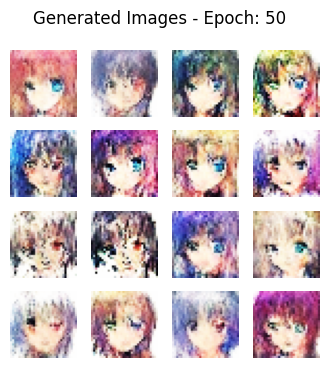

In [54]:
# Generate and display final images
generate_and_display_images(generator, EPOCHS, seed)